# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

**Tecnológico de Monterrey**

Prof Luis Eduardo Falcón Morales

### **Actividad: Problema de Clasificación con Datos Desbalanceados**

* #### **Nombre: ERICK ALAN CUELLAR QUINTANILLA**
* #### **Matrícula: A01383577**

# **Introducción**

* La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

* En la web puedes encontrar otros archivos del mismo problema pero con diversos cambios, por lo que el archivo con el que trabajarás está en Canvas y así poder asegurar que todos están trabajando con los mismos datos. Aún en una misma página, con el tiempo se actualiza y los datos inclusive pueden ya no estar accesibles.

* El archivo de los datos con el que trabajarás está en Canvas con el nombre "oil-spill.csv".

En la siguiente liga se encuentra el artículo original relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico, donde cada valor es una medida de información en la imagen. La última columna llamada "target" es de valor 1 (hay derrame en ese pedazo de la imagen) o 0 (no hay derrame en ese pedazo de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

Por el momento es suficiente con que consideres que cada una de las 49 columnas te da información de la imagen que te ayuda a entenderla mejor. En un curso posterior de visión computacional podrás ahondar sobre cómo extraer información numérica de una imagen.

En la siguiente liga puedes encontrar información de varias de las métricas de scikit-learn que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La librería de scikit-learn no incluye la media geométrica **G_mean**, pero sabemos que se puede obtener con la fórmula $G_{mean}=\sqrt{\frac{VP*VN}{(VP+FN) * (VN+FP)}}$, usando los verdaderos y falsos, positivos y negativos.

Sin embargo, para fines de esta actividad usaremos la librería llamada "imbalanced-learn" que incluye dicha métrica, además de un reporte más extenso de otras métricas útiles para estos casos de datos desbalanceados:

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

# **Ejercicio-1**

### **En esta actividad usaremos la media geométrica G_mean como métrica principal para buscar el mejor modelo. Explica a continuación cuándo se recomienda utilizar **G_mean** en un problema de aprendizaje supervisado (a) y su diferencia o diferencias con **f1_score** (b):**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**


* a) La métrica G_mean se utiliza para buscar el mejor modelo en datasets desbalanceados. Esto se debe a que considera tanto la especifidad y sensibilidad en su cálculo; en casos de datos desbalanceados, utilizar métodos convencionales de aprendizaje nos dará resultados poco confiables con la clase minoritaria. Este tipo de desbalances no se aprecia tanto con métricas como el accuracy, donde un modelo que simplemente esté "prediciendo" una sola clase nos dará como mínimo el porcentaje de la clase mayoritaria, e.g. predecir solamente la clase mayoritaria en un modelo con datos 90/10 nos daría un accuracy del 90%. 

* b) El f1_score es una métrica de precision y sensibilidad, la cual no toma en cuenta los verdaderos negativos, a diferencia de la G_mean, que si los toma en cuenta con la especifidad. En términos sencillos, el f1_score toma en cuenta 3 de los 4 cuadrantes de la matriz de confusión, mientras que la G_mean toma los 4 cuadrantes.



**+++++++++++ Termina sección para agregar texto ++++++++++++++**

In [171]:
# Incluye todas las librerías que consideres adecuadas:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from statistics import mean
from statistics import stdev as std

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, make_scorer, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_validate, train_test_split

from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

Para fines de la actividad pre-procesaremos los datos de manera estándar para concentrarnos en los temas relacionados al curso.

In [172]:
# Cargamos los datos del arcivo:
path ='oil_spill.csv'
df = pd.read_csv(path)

# Eliminamos las siguientes columnas:
df.drop("f_1", axis=1, inplace=True)    # Esta columna contiene información de secciones (batches) de las imágenes que no requerimos para esta actividad.
df.drop("f_23", axis=1, inplace=True)   # Esta columna tiene un solo valor constante.

print('Dimensión del DataFrame',df.shape)
df.head(3)


Dimensión del DataFrame (937, 48)


,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,214.7,...,2850.0,1000.0,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,901.7,...,5750.0,11500.0,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,86.1,...,1400.0,250.0,150.00,45.13,9.33,1,31692.84,65.81,7.84,1


In [173]:
# Particionamos en los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

# Utilizamos las semillas indicadas para la reproducibilidad de los resultados:
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=1)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=7)


# Veamos la partición de los tres conjuntos para que observes la poca cantidad de datos que se tienen en la clase minoritaria:
print('\nPartición:')
tmp = 100 * (ytrain.sum() / len(ytrain))
print('Train: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%, Porcentaje_clase_negativa=%.2f%%' % (ytrain.sum(), tmp, 100-tmp))
tmp = 100 * (yval.sum() / len(yval))
print('Val: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%, Porcentaje_clase_negativa=%.2f%%' % (yval.sum(), tmp, 100-tmp))
tmp = 100 * (ytest.sum() / len(ytest))
print('Test: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f, Porcentaje_clase_negativa=%.2f%%%%' % (ytest.sum(), tmp, 100-tmp))


Partición:
Train: Conteo_clase_positiva=28, Porcentaje_clase_positiva=4.25%, Porcentaje_clase_negativa=95.75%
Val: Conteo_clase_positiva=8, Porcentaje_clase_positiva=4.85%, Porcentaje_clase_negativa=95.15%
Test: Conteo_clase_positiva=5, Porcentaje_clase_positiva=4.42, Porcentaje_clase_negativa=95.58%%


#### **Breve descripción numérica y gráfica del conjunto de entrenamiento:**

In [174]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
f_2,659.0,350.377845,1.911459e+03,10.00,19.000,63.00,134.000,28526.00
f_3,659.0,692.040516,6.013521e+02,1.92,83.905,646.26,1229.325,1789.13
f_4,659.0,853.822398,5.259526e+02,1.00,435.500,719.81,1238.040,2724.57
f_5,659.0,85.613050,4.564260e+01,0.00,54.000,74.00,120.500,180.00
f_6,659.0,831366.966616,4.158159e+06,71718.00,125000.000,185000.00,337500.000,71315000.00
f_7,659.0,43.517132,1.287405e+01,21.24,33.760,40.35,53.090,82.64
f_8,659.0,9.244294,3.590490e+00,1.21,6.935,8.33,11.045,23.47
f_9,659.0,4094.624431,8.960913e+03,704.00,1332.000,2100.00,3445.000,160740.00
f_10,659.0,0.221730,8.687786e-02,0.02,0.170,0.21,0.260,0.67
f_11,659.0,110.794537,6.187135e+01,41.00,84.400,100.10,116.300,901.70


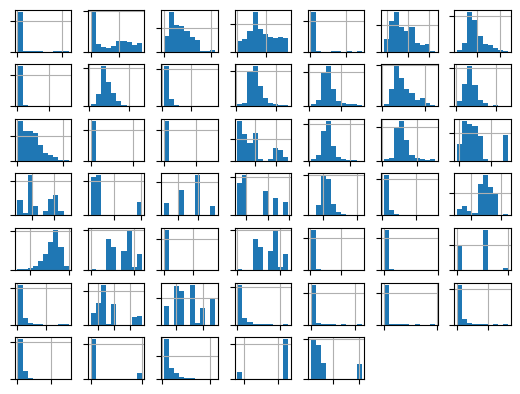

In [175]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()


In [176]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 433 to 625
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_2     659 non-null    int64  
 1   f_3     659 non-null    float64
 2   f_4     659 non-null    float64
 3   f_5     659 non-null    int64  
 4   f_6     659 non-null    float64
 5   f_7     659 non-null    float64
 6   f_8     659 non-null    float64
 7   f_9     659 non-null    float64
 8   f_10    659 non-null    float64
 9   f_11    659 non-null    float64
 10  f_12    659 non-null    float64
 11  f_13    659 non-null    float64
 12  f_14    659 non-null    float64
 13  f_15    659 non-null    float64
 14  f_16    659 non-null    float64
 15  f_17    659 non-null    float64
 16  f_18    659 non-null    float64
 17  f_19    659 non-null    float64
 18  f_20    659 non-null    float64
 19  f_21    659 non-null    float64
 20  f_22    659 non-null    float64
 21  f_24    659 non-null    float64
 22  f_25 

En resumen:
* De lo anterior observamos que todos los valores ya son numéricos positivos y negativos, no hay datos perdidios, la diferencia de escala entre todos los factores es muy diversa y la distribución de las variables también es muy variada.

* Como una primera aproximación transformaremos todos los factores con la Yeo-Johnson para corregir un poco el sesgo de las distribuciones que suele afectar en general a los modelos como la regresión logística y luego los escalaremos .

# **Ejercicio-2**

### **Investiga: (a) En qué consiste la transformación Yeo-Johnson y (b) cuál es su diferencia con la Box-Cox.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**


* a) La transformación de Yeo Johnson es una transformación que busca normalizar la distribución de los datos, reduciendo la asimetría de estos.

* b) La diferencia con Box-Cox es principalmente que esta última solamente puede transformar datos positivos, mientras que el método de Yeo Johnson permite normalizar datos negativos y ceros.



**+++++++++++ Termina sección para agregar texto ++++++++++++++**

In [177]:
# Código-1:

# Aplicamos la función Dummy con la métrica G-mean:

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


modeloD = DummyClassifier(strategy='uniform', random_state=7)
scores = evaluate_model(Xtrain, ytrain, modeloD)

print('Métrica G-mean[Media Geométrica] y (std): %.3f (%.3f)' % (mean(scores), std(scores)))


Métrica G-mean[Media Geométrica] y (std): 0.461 (0.241)


# **Ejercicio-3**

### **Explica lo que hace cada línea de código de la celda anterior llamada "Código-1", así como el significado de los valores que se obtienen en la salida:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

**NOTA AL PROFESOR: la descripción puede ser algo diferente a lo que comento aquí:**


1.   Elemento de lista
2.   Elemento de lista
3.   Elemento de lista
4.   Elemento de lista
5.   Elemento de lista
6.   Elemento de lista
7.   Elemento de lista
8.   Elemento de lista
9.   Significado del valor de salida:

La función evaluate_model es definida con 3 parametros de entrada, los cuales son los datos de entrada del modelo (X), los datos de salida (y), y nuestro modelo (model)

Posteriormente se define como cv al método de validación cruzada con k-Folds. En nuestra validación, nuestros datos se separarán en 10 partes iguales y se realizaran 3 iteraciónes de validación con diferente reparticion de datos. Random state = 1 establece la semilla 1 para el reordenamiento de nuestros datos.

La siguiente línea crea un scorer a partir de la métrica de g_mean. Esto lo convierte en un wrapper referenciable, y se usará para poder mandarlo como argumento posteriormente.

Después, utilizamos el cross_val_score para evaluar nuestro modelo por validación cruzada, y lo mandamos a llamar tanto con el modelo, como con los datos de entrada y de salida, así como con nuestro método de k-folds y el método de evaluación de g-mean. N-jobs = -1 determina el numero de hilos como el máximo posible (para hacer el proceso rápidamente). 

La función después regresará el resultado de cross_val_score, el cual es una lista de g_mean por cada iteración de la validación, que en este caso son 10 splits x 3 iterations = array de 30 resultados.

Despues de la definción de la función, se usa crea un modelo dummy con la estrategia "uniform" el cual otorga salidas totalmenta aleatorias sin depender de las entradas. Random state = 7 establece la semilla 7 para la aleatoriedad de los resultados.

Mandamos a llamar la funcion de evaluate_model con el modelo dummy,y nuestros datos de entrada y salida, registrando las validaciones con g_mean en la variable scores.

Finalmente, imprimimos la media y desviación estándar de nuestros resultados.


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

#### **Para fines de esta actividad definimos las siguientes transformaciones del preprocesamiento de los datos. Recuerda que aunque estos datos no tengan datos perdidos, simpre debes incluir una opción para el caso con datos futuros:**

In [178]:
# Transforamaciones numéricas que evitará el filtrado de información:


numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('yeo-johnson', PowerTransformer()),
                                       ('std_transformer', StandardScaler()),
                                       ])

numericas_pipeline_nombres = Xtrain.columns

columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)],
                                        remainder='passthrough')

In [179]:
mi_metrica = make_scorer(geometric_mean_score)  # definimos la métrica G-mean

Resultados de Validación:
LR
Exactitud: >> 0.947 (0.014)
G-mean: >> 0.653 (0.118)

LASSO
Exactitud: >> 0.960 (0.009)
G-mean: >> 0.501 (0.158)

RIDGE
Exactitud: >> 0.959 (0.008)
G-mean: >> 0.541 (0.113)

EN
Exactitud: >> 0.960 (0.007)
G-mean: >> 0.540 (0.109)

kNN
Exactitud: >> 0.956 (0.006)
G-mean: >> 0.174 (0.187)



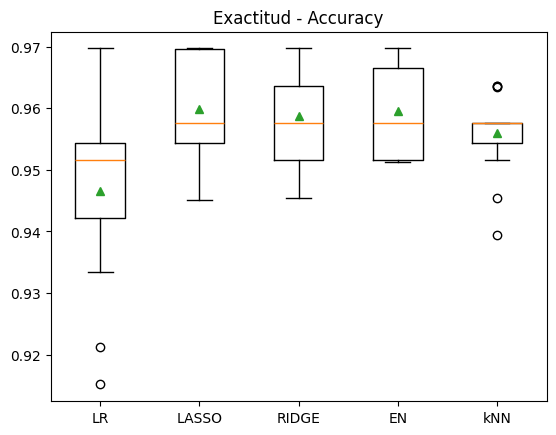

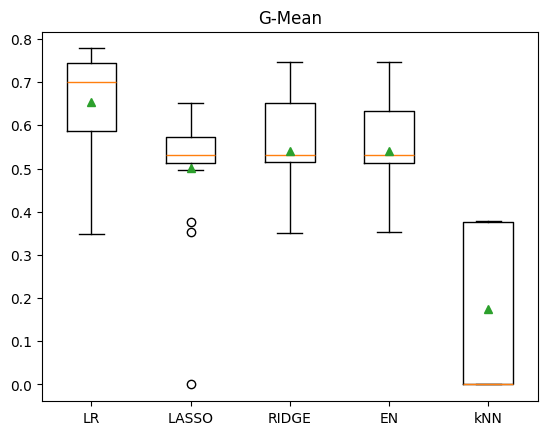

In [180]:
# Código-2:


def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, tick_labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, tick_labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-4**

### **a) Explica por qué la salida y gráficos anteriores nos ayudan a respaldar la decisión de usar la métrica G-mean, en lugar de la exactitud (accuracy) en este problema.**

### **b) En particular, indica cuáles de los modelos que obtuviste están subentrenados con respecto a la métrica de la exactitud (accuracy), en caso de que haya.**

### **c) Indica cuáles de los modelos que obtuviste están subentrenados con respecto a la métrica de la media geométrica, en caso de haya.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

* a) Todos nuestros modelos tienen un porcentaje superior al 94% de accuracy, lo cual puede aparentar como un buen modelo, pero el Gmean indica que, en realidad, los modelos no parecen estar bien entrenados en nuestra clase minoritaria, pues el mejor de los casos indica un 65% de media geometrica, la cual incluye la tasa de verdaderos positivos sobre la clase real positiva y la tasa de verdaderos negativos sobre la clase real negativa.

* b) Nuestro procentaje de datos mayoritarios en el dataset de entrenamiento es de 95.75%. Con base en eso, los metodos de Regresion Logistica (metodo clasico, sin penalizaciones) y kNN, al estar debajo de ese porcentaje, estan subentrenados.

* c) Particularmente, el G-mean de kNN esta significativamente subentrenado respecto al resto de modelos. Sin embargo, todos los modelos se podrían considerar subentrenados, ya que ninguno supera el 70%, dependiendo de la rigurosidad que manejemos.


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-5**

* ### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una nueva función llamada "mis_modelos_balanceados()" y utilízala para definir los mismos modelos anteriores, pero incluyendo el argumento class_weight='balanced'.**

* ### **Los demás hiperparámetros solo debes variarlos si es necesario, es decir, solo deberás ajustarlos para evitar errores o avisos (warnings) no deseados.**

* ### **Incluye también el modelo kNN, aunque no tenga el argumento para balanceo de las clases.**

Resultados de Validación:
LR
Exactitud: >> 0.913 (0.018)
G-mean: >> 0.754 (0.120)

LASSO
Exactitud: >> 0.877 (0.027)
G-mean: >> 0.804 (0.081)

RIDGE
Exactitud: >> 0.882 (0.023)
G-mean: >> 0.802 (0.083)

EN
Exactitud: >> 0.878 (0.025)
G-mean: >> 0.799 (0.083)

kNN
Exactitud: >> 0.956 (0.006)
G-mean: >> 0.174 (0.187)



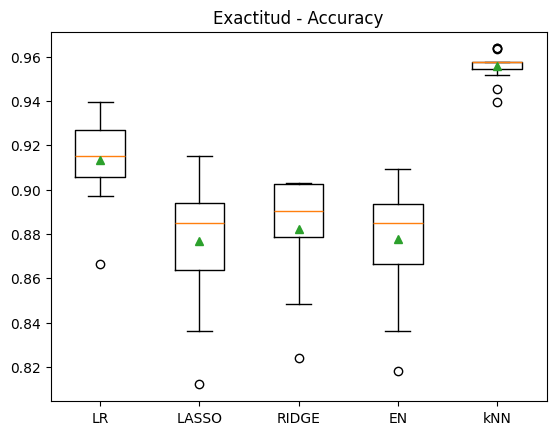

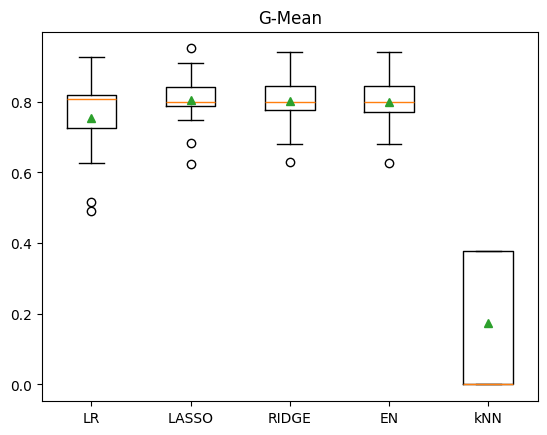

In [181]:

def mis_modelos_balanceados():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    class_weight='balanced',
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    class_weight='balanced',
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    class_weight='balanced',
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    class_weight='balanced',
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos_bal, nombres_bal = mis_modelos_balanceados()
resultados1_bal, resultados2_bal = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos_bal)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos_bal[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1_bal.append(scores['test_exactitud'])
  resultados2_bal.append(scores['test_m_geo'])

  print(nombres_bal[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1_bal, tick_labels=nombres_bal,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2_bal, tick_labels=nombres_bal,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-6**

**a) Selecciona el que consideres sea el mejor modelo encontrado, busca la mejor configuración de hiperparámetros y utilízalo para encontrar su matriz de confusión. Sigue utilizando los mismos conjuntos de entrenamiento y validación. Llamar "yval_hat" a las predicciones del conjunto de validación obtenidas con el mejor modelo.**

  **b) Con el mejor modelo obtener el gráfico de la curva-ROC, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo base (chance level).**

  **c) Con el mejor modelo obtener el gráfico de la curva-PR, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo base (chance level).**



**NOTA: En general cuando comparas modelos con Validación-Cruzada sin un ajuste mayor de hiperparámetros, el mejor modelo podría estar entre los de mayor desempeño y no necesariamente el que resultó con mayor valor. Por ello, en general deberías mantener la búsqueda entre los mejores encontrados.**

Mejor modelo: 0.787566 usando {'C': 0.02, 'solver': 'liblinear'}
G-mean del mejor modelo: 0.9065

Matriz de Confusión:
 [[129  28]
 [  0   8]]


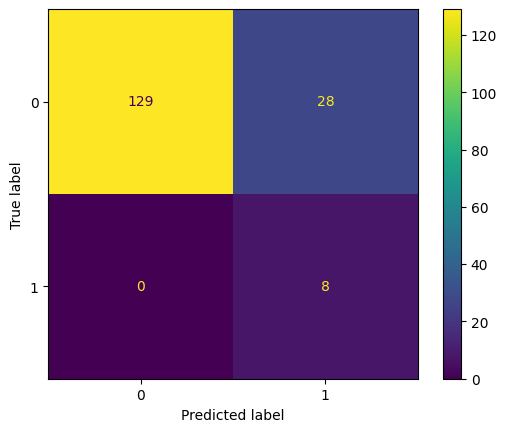

In [182]:
# 6a) Matriz de confusión

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

# +++++++++ Inicia sección para incluir tu código ++++++++++++++++++++++++

# Definimos el modelo de regresión logística sin los hiperparámetros optimizados:
ridge_model = LogisticRegression(penalty='l2',
                                    max_iter=5000,    # Incluye aquí todos los hiperparámetros y valores que consideres adecuados.
                                    class_weight='balanced',
                                    random_state=1)

# Definimos el diccionario de hiperparámetros a optimizar:
dicc_grid = {
    "C" : [0.01, 0.0125, 0.015, 0.0175, 0.02],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}   # Incluye aquí todas las líneas de código que consideres adecuadas.


# Definimos la validación cruzada y el GridSearchCV:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

grid = GridSearchCV(estimator=ridge_model,         # Aquí se usa el pipeline con el modelo
                    param_grid=dicc_grid,       # Aquí se usa el diccionario de hiperparámetros
                    cv = cv,                    # Aquí se usa la validación cruzada definida
                    scoring=mi_metrica,         # Aquí se usa la métrica G-mean
                    n_jobs=-1,
                    return_train_score=True)

# Transformamos los datos de entrenamiento:
Xx = columnasTransformer.fit_transform(Xtrain)

# Ajustamos el modelo con los datos de entrenamiento
grid_result = grid.fit(Xx, np.ravel(ytrain))

mejor_modelo_ridge = grid_result.best_estimator_

yval_hat = mejor_modelo_ridge.predict(columnasTransformer.transform(Xval))

print("Mejor modelo: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
print('G-mean del mejor modelo: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))
print("\nMatriz de Confusión:\n", confusion_matrix(np.ravel(yval), yval_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(np.ravel(yval), yval_hat)).plot()

Mejor modelo LR: 0.566113 usando {'C': 1, 'solver': 'lbfgs'}
G-mean del mejor modelo: 0.9643

Matriz de Confusión:
 [[146  11]
 [  0   8]]


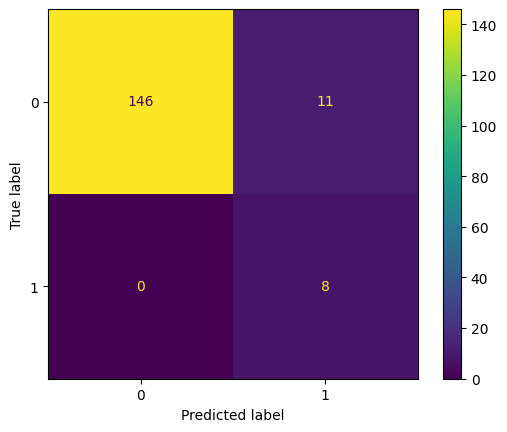

In [183]:
# Definimos el modelo de regresión logística sin los hiperparámetros optimizados:
lr_model = LogisticRegression(penalty=None,
                                    max_iter=5000,   
                                    class_weight='balanced',
                                    random_state=1)

# Definimos el diccionario de hiperparámetros a optimizar (En LR no es relevante, solamente lo coloco como placeholder para mantener la misma estructura)
dicc_grid = {
    "C" : [1],
    "solver": ['lbfgs'] 
}   

grid = GridSearchCV(estimator=lr_model,         # Aquí se usa el pipeline con el modelo y el preprocesamiento
                    param_grid=dicc_grid,       # Aquí se usa el diccionario de hiperparámetros
                    cv = cv,                    # Aquí se usa la validación cruzada definida
                    scoring=mi_metrica,         # Aquí se usa la métrica G-mean
                    n_jobs=-1,
                    return_train_score=True)


# Ajustamos el modelo con los datos de entrenamiento y validación (por validación cruzada con k-folds):
grid_result = grid.fit(Xx, np.ravel(ytrain))

mejor_modelo_lr = grid_result.best_estimator_

yval_hat = mejor_modelo_lr.predict(columnasTransformer.transform(Xval))

print("Mejor modelo LR: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
print('G-mean del mejor modelo: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))
print("\nMatriz de Confusión:\n", confusion_matrix(np.ravel(yval), yval_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(np.ravel(yval), yval_hat)).plot()

Mejor modelo: 0.830599 usando {'C': 0.057, 'solver': 'saga'}
G-mean del mejor modelo: 0.9375

Matriz de Confusión:
 [[138  19]
 [  0   8]]


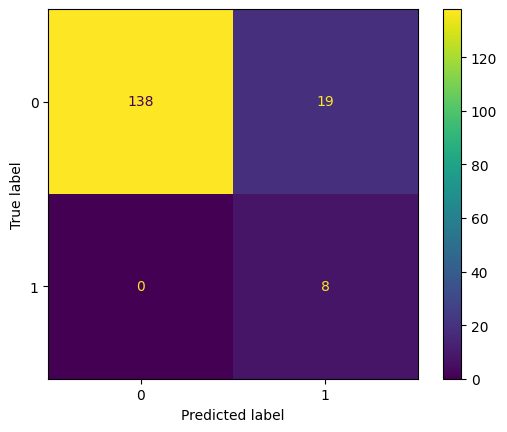

In [184]:
# Definimos el modelo de regresión logística sin los hiperparámetros optimizados:
lasso_model = LogisticRegression(penalty='l1',
                                    max_iter=5000,    
                                    class_weight='balanced',
                                    random_state=1)

# Definimos el diccionario de hiperparámetros a optimizar:
dicc_grid = {
    "C" : [0.056, 0.0565, 0.057, 0.0575],
    "solver": ['liblinear', 'saga']
}   


grid = GridSearchCV(estimator=lasso_model,         # Aquí se usa el pipeline con el modelo y el preprocesamiento
                    param_grid=dicc_grid,       # Aquí se usa el diccionario de hiperparámetros
                    cv = cv,                    # Aquí se usa la validación cruzada definida
                    scoring=mi_metrica,         # Aquí se usa la métrica G-mean
                    n_jobs=-1,
                    return_train_score=True)

# Ajustamos el modelo con los datos de entrenamiento y validación (por validación cruzada con k-folds):
grid_result = grid.fit(Xx, np.ravel(ytrain))

mejor_modelo_lasso = grid_result.best_estimator_

yval_hat = mejor_modelo_lasso.predict(columnasTransformer.transform(Xval))

print("Mejor modelo: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
print('G-mean del mejor modelo: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))
print("\nMatriz de Confusión:\n", confusion_matrix(np.ravel(yval), yval_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(np.ravel(yval), yval_hat)).plot()

Mejor modelo elasticnet: 0.832455 usando {'C': 0.03, 'l1_ratio': 0.7625}
G-mean del mejor modelo: 0.9307

Matriz de Confusión:
 [[136  21]
 [  0   8]]


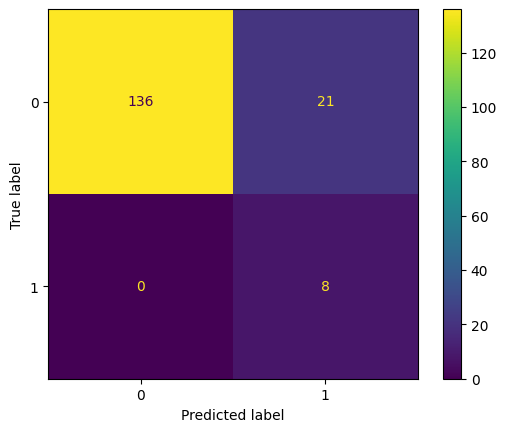

In [185]:

# Definimos el modelo de regresión logística sin los hiperparámetros optimizados:
en_model = LogisticRegression(penalty='elasticnet',
                                    max_iter=5000,    # Incluye aquí todos los hiperparámetros y valores que consideres adecuados.
                                    class_weight='balanced',
                                    solver='saga',
                                    random_state=1)

# Definimos el diccionario de hiperparámetros a optimizar:
dicc_grid = {
    "C" : [0.015, 0.02, 0.025, 0.03, 0.035],
    "l1_ratio": [0.7625, 0.775, 0.7875, 0.8, 0.8125],
}   # Incluye aquí todas las líneas de código que consideres adecuadas.

grid = GridSearchCV(estimator=en_model,         # Aquí se usa el pipeline con el modelo y el preprocesamiento
                    param_grid=dicc_grid,       # Aquí se usa el diccionario de hiperparámetros
                    cv = cv,                    # Aquí se usa la validación cruzada definida
                    scoring=mi_metrica,         # Aquí se usa la métrica G-mean
                    n_jobs=-1,
                    return_train_score=True)

# Ajustamos el modelo con los datos de entrenamiento y validación (por validación cruzada con k-folds):
grid_result = grid.fit(Xx, np.ravel(ytrain))

mejor_modelo_en = grid_result.best_estimator_

yval_hat = mejor_modelo_en.predict(columnasTransformer.transform(Xval))

print("Mejor modelo elasticnet: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


print('G-mean del mejor modelo: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))
print("\nMatriz de Confusión:\n", confusion_matrix(np.ravel(yval), yval_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(np.ravel(yval), yval_hat)).plot()

In [186]:

mejor_modelo = mejor_modelo_lasso
yval_hat = mejor_modelo.predict(columnasTransformer.transform(Xval))
print("Mejor modelo: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**


print('G-mean del mejor modelo: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))
print("\nMatriz de Confusión:\n", confusion_matrix(np.ravel(yval), yval_hat))


Mejor modelo: 0.832455 usando {'C': 0.03, 'l1_ratio': 0.7625}
G-mean del mejor modelo: 0.9375

Matriz de Confusión:
 [[138  19]
 [  0   8]]


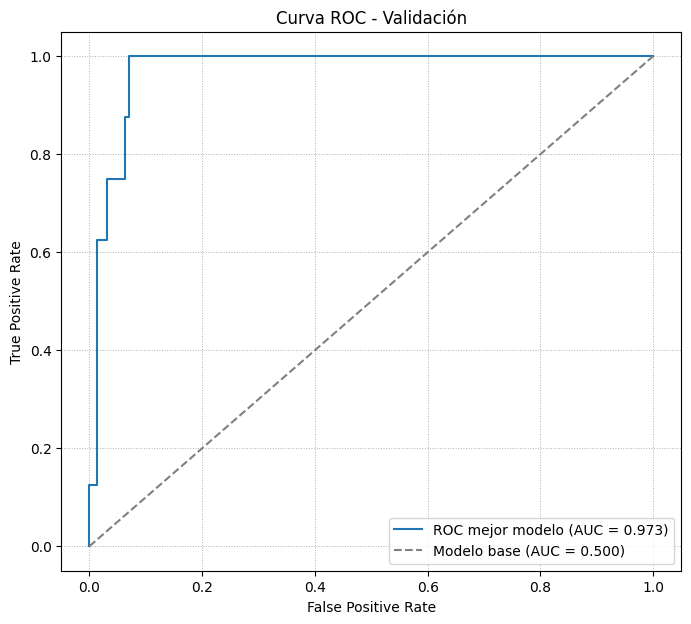

In [187]:
# 6b) Curva ROC:

# **+++++++++++ Inicia sección para agregar código ++++++++++++++**
yval_proba = mejor_modelo.predict_proba(columnasTransformer.transform(Xval))[:, 1]
fp, vp, _ = roc_curve(np.ravel(yval), yval_proba)
roc_auc = auc(fp, vp)

plt.figure(figsize=(8, 7))
plt.plot(fp, vp, label=f'ROC mejor modelo (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modelo base (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Validación')
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.7)
plt.show()

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

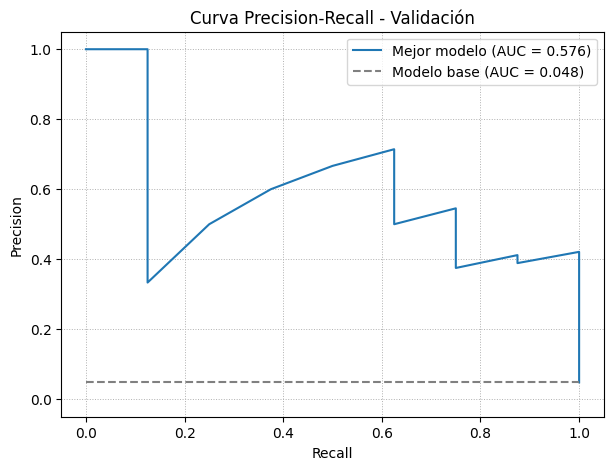

In [188]:
# 6c) Curva PR:

# **+++++++++++ Inicia sección para agregar código ++++++++++++++**


precision, recall, _ = precision_recall_curve(np.ravel(yval), yval_proba)
pr_auc = auc(recall, precision)
baseline_pr = np.mean(yval)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'Mejor modelo (AUC = {pr_auc:.3f})')
plt.hlines(baseline_pr, 0, 1, colors='gray', linestyles='--', label=f'Modelo base (AUC = {baseline_pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Validación')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.7)
plt.show()


# **+++++++++++ Termina sección para agregar código ++++++++++++++**

# **Ejercicio-7**

### **Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido previamente y obtener:**

**a) El valor de la media geométrica G_mean.**

**b) La matriz de confusión.**

**c) El reporte de métricas classification_report_imbalanced:**



In [189]:
# 7a)

print('G-mean del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.


ytest_hat = mejor_modelo.predict(columnasTransformer.transform(Xtest))
print(geometric_mean_score(np.ravel(ytest), ytest_hat))



# **+++++++++++ Termina sección para agregar código ++++++++++++++**

G-mean del mejor modelo con el conjunto de prueba (test):
0.9378857231185629


Matriz de confusión del mejor modelo con el conjunto de prueba (test):

 [[95 13]
 [ 0  5]]


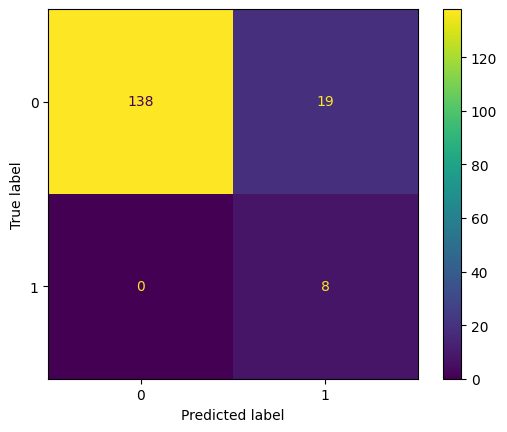

In [190]:
# 7b)

print('Matriz de confusión del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.


print("\n", confusion_matrix(np.ravel(ytest), ytest_hat))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(np.ravel(yval), yval_hat)).plot()

# **+++++++++++ Termina sección para agregar código ++++++++++++++**



In [191]:
# 7c)

print("Reporte de métricas con el conjunto de prueba (test):\n")

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.


print(classification_report_imbalanced(np.ravel(ytest), ytest_hat))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**



Reporte de métricas con el conjunto de prueba (test):

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.88      1.00      0.94      0.94      0.87       108
          1       0.28      1.00      0.88      0.43      0.94      0.89         5

avg / total       0.97      0.88      0.99      0.91      0.94      0.87       113



# **Ejercicio-8**

### **Incluye tus conclusiones finales de los resultados obtenidos y de la actividad en general.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



* Datos desbalanceados no solo requieren modelos con configuraciones diferentes, como el balanceo de clases, también requieren métricas que nos puedan ayudar a controlar correctamente su aprendizaje, tal y como lo hace la G_mean.

* Las matríces de confusión nos ayudaron a observar el comportamiento de nuestro modelo, pero la función classification_report_imbalanced nos ayuda con diferentes métricas que nos ayudan a corroborar las distintas métricas para nuestras dos clases, en las que también vimos un buen comportamiento de nuestro modelo final.

* Finalmente, la curva ROC nos mostró un comportamiento casi ideal de nuestro modelo con nuestros datos de validación, pero al tener clases desbalanceadas, necesitamos la curva PR para validar correctamente el modelo.


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **<<< Fin de la Actividad de la Semana - Oil Spill - Clases no balanceadas >>>**